# Imports

In [1]:
from scipy.io import loadmat

In [2]:
import numpy as np

In [3]:
import numpy.ma as ma

In [4]:
from numpy import linalg as LA

In [5]:
from PIL import Image

# Utility functions

In [6]:
def show_image(npimg):
    return Image.fromarray(npimg.astype(np.uint8))

In [7]:
def show_normals(npnorms):
    return Image.fromarray(((npnorms+1)/2*255).astype(np.uint8))

# Loading

In [8]:
mat = loadmat('../Code/Experiments/Outputs/VGG16.mat')

In [9]:
mat['Normals'].shape

(654, 240, 320, 3)

In [10]:
mat['Predictions'].shape

(654, 240, 320, 3)

# Data Set

In [11]:
import h5py
import numpy as np
import tensorflow as tf
import random

file = 'DataSets/MAT/NYUDataSet.mat'
testNdxs = [0,1,8,13,14,15,16,17,20,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,45,46,55,56,58,59,60,61,62,75,76,77,78,83,84,85,86,87,88,89,90,116,117,118,124,125,126,127,128,130,131,132,133,136,152,153,154,166,167,168,170,171,172,173,174,175,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,206,207,208,209,210,211,219,220,221,249,263,270,271,272,278,279,280,281,282,283,284,295,296,297,298,299,300,301,309,310,311,314,315,316,324,325,326,327,328,329,330,331,332,333,334,350,351,354,355,356,357,358,359,360,361,362,363,383,384,385,386,387,388,389,394,395,396,410,411,412,413,429,430,431,432,433,434,440,441,442,443,444,445,446,447,461,462,463,464,465,468,469,470,471,472,473,474,475,476,507,508,509,510,511,512,514,515,516,517,518,519,520,521,522,523,524,525,530,531,532,536,537,538,548,549,550,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,578,579,580,581,582,590,591,592,593,602,603,604,605,606,611,612,616,617,618,619,620,632,633,634,635,636,637,643,644,649,650,655,656,657,662,663,667,668,669,670,671,672,675,676,677,678,679,680,685,686,687,688,689,692,693,696,697,698,705,706,707,708,709,710,711,712,716,717,723,724,725,726,727,730,731,732,733,742,743,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,799,800,801,802,803,809,810,811,812,813,820,821,822,832,833,834,835,836,837,838,839,840,841,842,843,844,845,849,850,851,856,857,858,859,860,861,868,869,870,905,906,907,916,917,918,925,926,927,931,932,933,934,944,945,946,958,959,960,961,964,965,966,969,970,971,972,973,974,975,976,990,991,992,993,994,1000,1001,1002,1003,1009,1010,1011,1020,1021,1022,1031,1032,1033,1037,1038,1047,1048,1051,1052,1056,1057,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1087,1088,1089,1090,1091,1092,1093,1094,1095,1097,1098,1099,1100,1101,1102,1103,1105,1106,1107,1108,1116,1117,1118,1122,1123,1124,1125,1126,1127,1128,1129,1130,1134,1135,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1161,1162,1163,1164,1165,1166,1169,1170,1173,1174,1175,1178,1179,1180,1181,1182,1183,1191,1192,1193,1194,1195,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1215,1216,1217,1218,1219,1225,1226,1227,1228,1229,1232,1233,1234,1246,1247,1248,1249,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1274,1275,1276,1277,1278,1279,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1296,1297,1298,1301,1302,1303,1304,1305,1306,1307,1313,1314,1328,1329,1330,1331,1334,1335,1336,1337,1338,1339,1346,1347,1348,1352,1353,1354,1355,1363,1364,1367,1368,1383,1384,1385,1386,1387,1388,1389,1390,1393,1394,1395,1396,1397,1398,1399,1400,1406,1407,1408,1409,1410,1411,1412,1413,1420,1421,1422,1423,1429,1430,1431,1432,1440,1441,1442,1443,1444,1445,1446,1447,1448]


class Dataset:
    def __init__(self, subset= testNdxs, seed=1,
                 batch_res=(240,320), scale=(1.0,1.5), flip=True, color=True):
        '''
        subset: A list of the index of images
        '''
        # Load dataset file
        self.dataset = h5py.File(file,'r')

        # Load images and normals (index, height, width, channels)
        self.images = np.array(self.dataset['images']).transpose([0,3,2,1])
        self.normals = np.array(self.dataset['normals']).transpose([0,3,2,1])

        # Dataset height and width
        self.width = self.images.shape[2]
        self.height = self.images.shape[1]
        # Output height and width
        self.batch_height = batch_res[0]
        self.batch_width = batch_res[1]

        #Scaling factors in respect to batch resolution
        if(min(scale) < 1.0):
            print("Error: Scaling factor is in respect to batch_res and must be greater than 1.0 ")
        else:
            self.scale = scale

        # Subset
        if subset == None: # Use all images
            self.validIndices = list(range(self.images.shape[0]))
        else: # Use a subset of dataset
            self.validIndices = subset

        # Number of usable samples in the dataset
        self.size = len(self.validIndices)

        # Random flip
        self.flip = flip

        # Random color changes
        self.change_color = color
        self.maxHueDelta = 0.1
        self.maxSatDelta = 0.5

        # Queue for choosing the samples
        self.queue = []

        # Random seed
        self.seed = seed
        random.seed(seed)

        # Building the computional graph
        self._build_tf_graph()

    def _build_tf_graph(self):

        # Creating the tf session
        tf.set_random_seed(self.seed)
        self.sess = tf.Session()

        # Input placeholders
        self.tfImgs = tf.placeholder(tf.float32, shape=(None, self.height, self.width, 3))
        self.tfNorms = tf.placeholder(tf.float32, shape=(None, self.height, self.width, 3))

        # Scaling
        # Randomly chooses a scaling factor
        scales = tf.convert_to_tensor(self.scale)
        rand_index = tf.random_uniform([], minval=0, maxval=2, dtype=tf.int32)
        rand_scale = scales[rand_index]
        # Scales
        size = tf.cast([self.batch_height*rand_scale, self.batch_width*rand_scale], tf.int32)
        reszImgs = tf.image.resize_images(self.tfImgs, size)
        reszNorms = tf.image.resize_images(self.tfNorms, size)
        normNorms = tf.nn.l2_normalize(reszNorms,3)

        # Random Crop
        # Random height offset
        maxHeightIndex = size[0] - 240
        heightIndex = tf.random_uniform([], minval=0, maxval=maxHeightIndex+1, dtype=tf.int32)
        # Random width offset
        maxWidthIndex = size[1] - 320
        widthIndex = tf.random_uniform([], minval=0, maxval=maxWidthIndex+1, dtype=tf.int32)
        # Crops
        cropImgs = tf.image.crop_to_bounding_box(reszImgs, heightIndex, widthIndex, 240, 320)
        cropNorms = tf.image.crop_to_bounding_box(normNorms, heightIndex, widthIndex, 240, 320)

        # Flip , this is a lazy definition, its excution depends on the rand_flip
        flipImgs = tf.reverse(cropImgs,[2])
        revNorms = tf.reverse(cropNorms,[2])
        flipNorms = tf.multiply([-1.0,1.0,1.0],revNorms)
        # Random flip
        rand_flip = tf.cast(tf.random_uniform([], minval=0, maxval=2, dtype=tf.int32), tf.bool)
        randFlipImgs = tf.cond(rand_flip, lambda: flipImgs, lambda: cropImgs) #Flip or last value
        randFlipNorms = tf.cond(rand_flip, lambda: flipNorms, lambda: cropNorms) # Flip or last value

        # Random color changes
        change_color = tf.cast(self.change_color, tf.bool)
        # Delta values
        hueDelta = tf.random_uniform([], -self.maxHueDelta, self.maxHueDelta)
        satFactor = tf.random_uniform([], 1.0-self.maxSatDelta, 1.0+self.maxSatDelta)
        # Convert image RGB values to [0,1] range
        rngImgs = tf.clip_by_value(tf.divide(randFlipImgs, 255.0), 0.0, 1.0)
        # Convert RGB images to HSV
        hsvImgs = tf.image.rgb_to_hsv(rngImgs)
        hue = tf.slice(hsvImgs, [0, 0, 0, 0], [-1, -1, -1, 1])
        saturation = tf.slice(hsvImgs, [0, 0, 0, 1], [-1, -1, -1, 1])
        value = tf.slice(hsvImgs, [0, 0, 0, 2], [-1, -1, -1, 1])
        # Change hue and saturation
        hue = tf.cond(change_color, lambda: tf.mod(hue + (hueDelta + 1.), 1.), lambda: hue)
        saturation = tf.cond(change_color, lambda: tf.clip_by_value(saturation*satFactor, 0.0, 1.0), lambda: saturation)
        # Convert to RGB
        hsv = tf.concat([hue, saturation, value], 3)
        colorImgs = tf.image.hsv_to_rgb(hsv)

        # Outputs
        self.tfOutImgs = tf.image.convert_image_dtype(colorImgs, tf.uint8, saturate=True)
        self.tfOutNorms = randFlipNorms

    def _next_index(self):

        if (len(self.queue) == 0):
            self.queue = self.validIndices[:]
            random.shuffle(self.queue)

        return self.queue.pop()

    def get_batch(self, batch_size=32):
        ''' A batch with data augmentation '''
        images = np.empty([batch_size, self.height, self.width, 3], dtype=np.float32)
        normals = np.empty([batch_size, self.height, self.width, 3], dtype=np.float32)

        for i in range(batch_size):
            ni = self._next_index()
            images[i,:,:,:] = self.images[ni,:,:,:]
            normals[i,:,:,:] = self.normals[ni,:,:,:]

        (outImgs, outNorms) = self.sess.run((self.tfOutImgs,self.tfOutNorms),
                                            feed_dict={self.tfImgs: images, self.tfNorms: normals})
        return outImgs, outNorms

    def get_data(self, index):
        ''' Resized original data: Image and normal map'''

        image = self.images[index,:,:,:]
        normals = self.normals[index,:,:,:]

        tfSize = tf.constant([self.batch_height,self.batch_width], dtype=tf.int32)
        tfImg = tf.constant(image)
        tfNorms = tf.constant(normals)
        reszImgs = tf.image.resize_images(tfImg, tfSize)
        reszNorms = tf.image.resize_images(tfNorms, tfSize)
        normNorms = tf.nn.l2_normalize(reszNorms, 2)
        (outImg, outNorms) = self.sess.run((reszImgs, normNorms))

        return outImg, outNorms


In [12]:
%ls ../Code/DataSets/MAT/NYUDataSet.mat

../Code/DataSets/MAT/NYUDataSet.mat


In [13]:
file = '../Code/DataSets/MAT/NYUDataSet.mat'

In [14]:
dataset = Dataset()

In [15]:
dataset.size

654

In [16]:
dataset.validIndices

[0,
 1,
 8,
 13,
 14,
 15,
 16,
 17,
 20,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 45,
 46,
 55,
 56,
 58,
 59,
 60,
 61,
 62,
 75,
 76,
 77,
 78,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 116,
 117,
 118,
 124,
 125,
 126,
 127,
 128,
 130,
 131,
 132,
 133,
 136,
 152,
 153,
 154,
 166,
 167,
 168,
 170,
 171,
 172,
 173,
 174,
 175,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 206,
 207,
 208,
 209,
 210,
 211,
 219,
 220,
 221,
 249,
 263,
 270,
 271,
 272,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 309,
 310,
 311,
 314,
 315,
 316,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 350,
 351,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 394,
 395,
 396,
 410,
 411,
 412,
 413,
 429,
 430,
 431,
 432,
 433,
 434,
 440,
 441,
 442,
 443,

# Evaluation

In [17]:
Preds = mat['Predictions']

In [18]:
shape = Preds.shape

In [19]:
shape

(654, 240, 320, 3)

In [20]:
Norms = np.empty([shape[0], dataset.height, dataset.width, 3], dtype=np.float32)

In [33]:
shape = Norms.shape

In [30]:
index = 0
for i in dataset.validIndices:
    Norms[index] = dataset.normals[i]
    index += 1

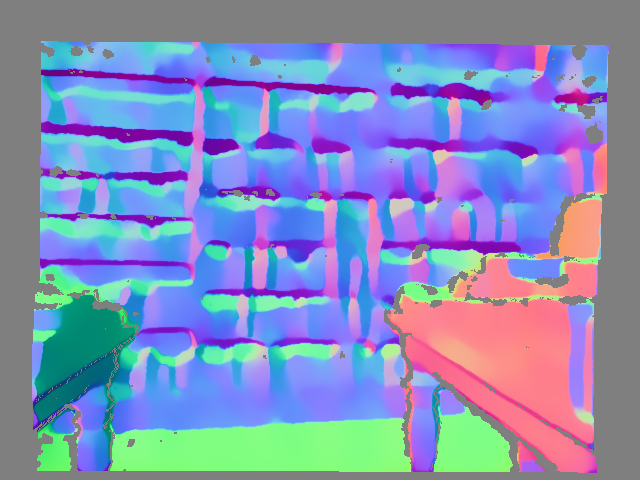

In [31]:
show_normals(Norms[39])

In [34]:
Norms = np.divide(Norms,np.reshape(LA.norm(Norms,axis=3), (shape[0],shape[1],shape[2],1)))

/home/raman/Applications/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [35]:
Norms = np.nan_to_num(Norms)

In [36]:
np.unique(LA.norm(Norms,axis=3))

array([ 0.        ,  0.99999988,  0.99999994,  1.        ,  1.00000012], dtype=float32)

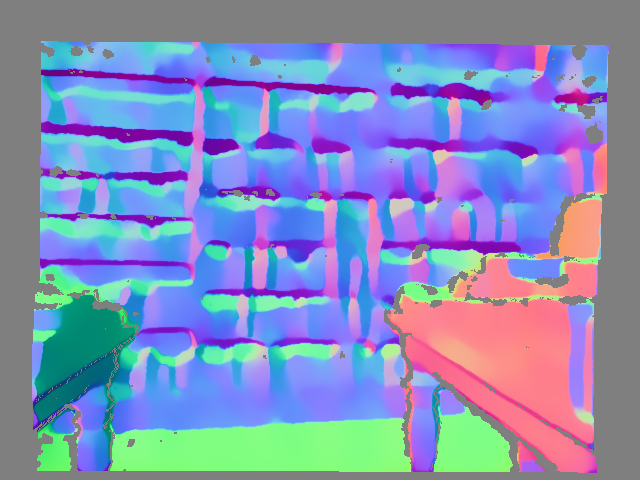

In [37]:
show_normals(Norms[39])

In [38]:
Masks = np.all(Norms,axis=3)

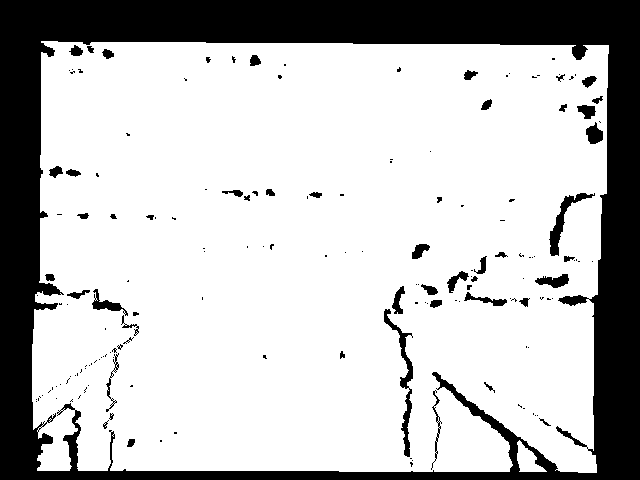

In [39]:
show_image(Masks[39]*255)

In [41]:
with tf.device('/cpu:0'):
    tfSize = tf.constant([dataset.height,dataset.width], dtype=tf.int32)
    tfPreds = tf.constant(Preds)
    reszPreds = tf.image.resize_images(tfPreds, tfSize)
    normPreds = tf.nn.l2_normalize(reszPreds, 2)
sess = tf.Session()
Preds = sess.run(normPreds)

In [45]:
Preds = np.divide(Preds,np.reshape(LA.norm(Preds,axis=3), (shape[0],shape[1],shape[2],1)))

/home/raman/Applications/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [46]:
Preds = np.nan_to_num(Preds)

In [47]:
np.unique(LA.norm(Preds,axis=3))

array([ 0.        ,  0.99999982,  0.99999988,  0.99999994,  1.        ,
        1.00000012], dtype=float32)

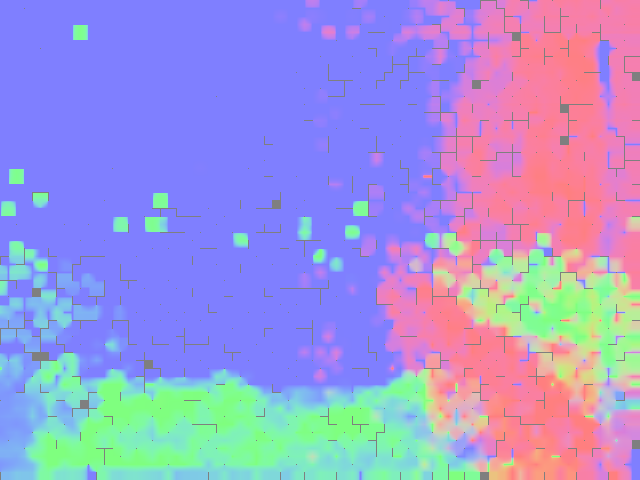

In [48]:
show_normals(Preds[39])

In [49]:
Dot = np.sum(np.multiply(Norms,Preds),axis=-1)

In [50]:
Dot.shape

(654, 480, 640)

In [51]:
Dot = np.clip(Dot, -1,1)

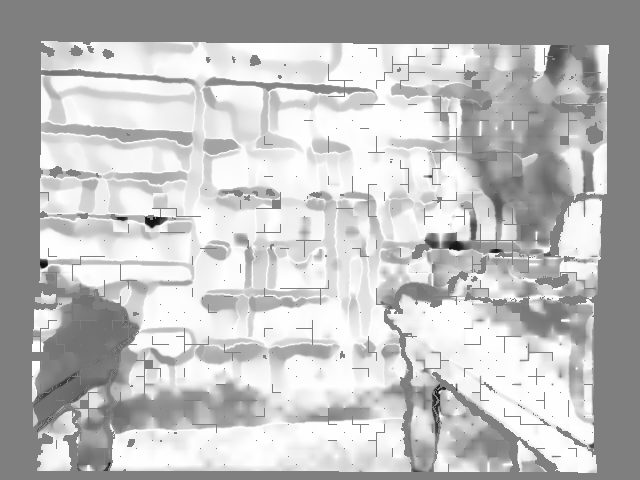

In [52]:
show_normals(Dot[39])

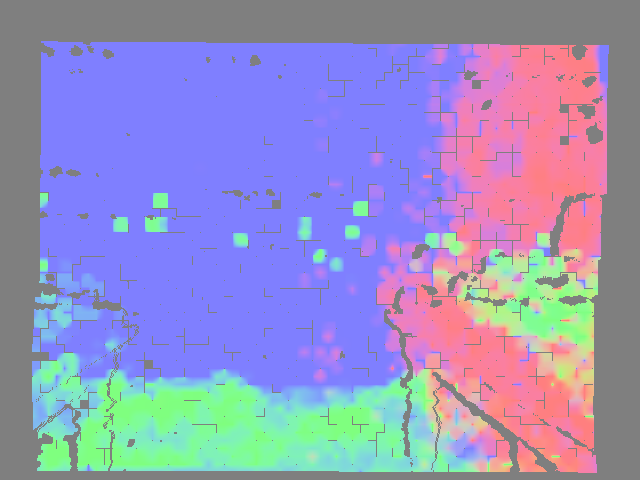

In [53]:
show_normals(Preds[39]*np.expand_dims(Masks[39], axis=2))

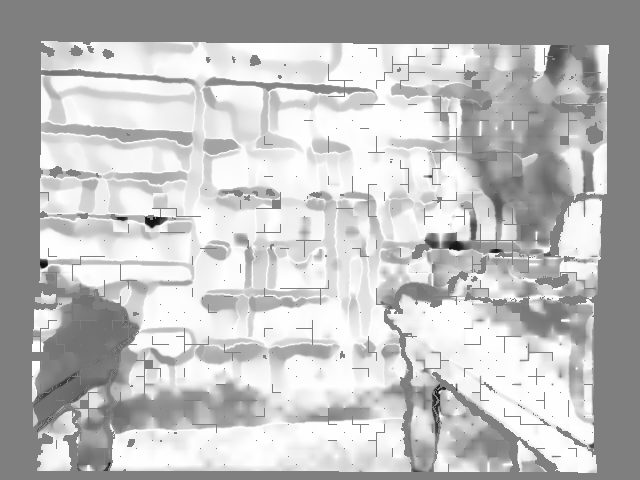

In [54]:
show_normals(Dot[39]*Masks[39])

In [55]:
Err = ma.masked_array(np.rad2deg(np.arccos(Dot)), ~Masks)

In [56]:
Err.mean()

43.170439547928048

In [57]:
np.mean(np.less(Err, 11.25).astype(np.float32))*100

11.018518129255048

In [58]:
Err = Err.compressed()

In [59]:
Summary = {'Mean':float(np.mean(Err)),
          'Median':float(np.median(Err)),
          'RMSE':float(np.sqrt(np.mean(np.power(Err,2)))),
          '11.25':np.mean(np.less(Err, 11.25).astype(np.float32))*100,
          '22.5':np.mean(np.less(Err, 22.5).astype(np.float32))*100,
          '30':np.mean(np.less(Err, 30).astype(np.float32))*100,
          '45':np.mean(np.less(Err, 45).astype(np.float32))*100}

In [60]:

Summary

{'11.25': 11.018518358469009,
 '22.5': 27.889606356620789,
 '30': 38.527023792266846,
 '45': 57.257997989654541,
 'Mean': 43.1705207824707,
 'Median': 38.9879264831543,
 'RMSE': 50.918556213378906}

In [145]:
import json

In [146]:
json.dumps(Summary)

'{"Mean": 41.35591125488281, "Median": 36.82966995239258, "RMSE": 49.13106918334961, "11.25": 12.458500266075134, "22.5": 30.244261026382446, "30": 41.094136238098145, "45": 59.958332777023315}'

# Code

In [147]:
#%%writefile ../Code/Experiments/Evaluation.py
# Imports
import json
import numpy as np
import numpy.ma as ma
from numpy import linalg as LA

def Evaluate(ID, groundTruth, predictions):
    shape = groundTruth.shape
    # Normalization
    Norms = np.divide(groundTruth,np.reshape(LA.norm(groundTruth,axis=3), (shape[0],shape[1],shape[2],1)))
    Preds = np.divide(predictions,np.reshape(LA.norm(predictions,axis=3), (shape[0],shape[1],shape[2],1)))
    Norms = np.nan_to_num(Norms)
    Preds = np.nan_to_num(Preds)
    # Mask of valid values
    Masks = np.all(Norms,axis=3)
    # Dot product
    Dot = np.sum(np.multiply(Norms,Preds),axis=-1)
    Dot = np.clip(Dot, -1,1)
    # Error
    Err = np.rad2deg(np.arccos(Dot))
    Err = ma.masked_array(Err, ~Masks)
    Err = Err.compressed()
    # Stats
    Stats = {
        'Mean':float(np.mean(Err)),
        'Median':float(np.median(Err)),
        'RMSE':float(np.sqrt(np.mean(np.power(Err,2)))),
        '11.25':np.mean(np.less(Err, 11.25).astype(np.float32))*100,
        '22.5':np.mean(np.less(Err, 22.5).astype(np.float32))*100,
        '30':np.mean(np.less(Err, 30).astype(np.float32))*100,
        '45':np.mean(np.less(Err, 45).astype(np.float32))*100,}
    # Saving the results
    with open('Experiments/Outputs/'+ ID + '.eval', 'w') as fp:
        json.dump(Stats, fp)

Overwriting ../Code/Experiments/Evaluation.py
